# Make Results Figures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
architecture = 'fcn2'
branches = 2
shared_frac_list = [0, 0.25, 0.5, 0.75, 1]

## Ensemble

In [3]:
df = pd.read_csv('results/mnist-{}/B{}-test.csv'.format(architecture, branches))

In [4]:
df

,Unnamed: 0,acc_1,acc_2,after_mean_acc,before_mean_acc,model_id_1,model_id_2
0,0,0.9518,0.9494,0.9549,0.9551,1,5
1,0,0.9435,0.9473,0.9519,0.9519,3,8
2,0,0.9527,0.9486,0.9571,0.9572,2,4
3,0,0.9518,0.9429,0.9522,0.9531,1,6
4,0,0.9494,0.9429,0.9532,0.9544,5,6
5,0,0.9435,0.9527,0.9511,0.9516,3,2
6,0,0.9518,0.9429,0.9522,0.9531,1,6
7,0,0.9429,0.9518,0.9522,0.9531,6,1


In [5]:
avg_acc = df['before_mean_acc'].mean()
std_acc = df['before_mean_acc'].std()
print(avg_acc, std_acc)

0.9536875 0.0018294710398676344


## Baseline

In [6]:
baseline_val_acc = []
for i in range(8):
    df = pd.read_csv('results/mnist-{}/train_{}.csv'.format(architecture, i+1))
    baseline_val_acc.append(df.iloc[-1]['val_acc'])
baseline = np.mean(baseline_val_acc)
print(baseline)

0.9477875009179115


In [7]:
print(baseline_val_acc)

[0.9517999887466432, 0.9527000188827516, 0.9434999823570251, 0.9485999941825868, 0.9494000077247621, 0.942900002002716, 0.9460999965667723, 0.9473000168800354]


## Virtual Branching

In [8]:
results = {}
results_std = {}
for frac in shared_frac_list:
    val_acc = []
    for i in range(4):
        df = pd.read_csv('results/vb-mnist-{}/B{}/S{:.2f}/train_{}.csv'.format(architecture, branches, frac, i+1))
        val_acc.append(df.iloc[-1]['val_acc_ensemble'])
    print(frac, val_acc)
    results[frac] = np.mean(val_acc)
    results_std[frac] = np.std(val_acc)

0 [0.9546999931335448, 0.9560999870300292, 0.9544000029563904, 0.9531999826431274]
0.25 [0.9560999870300292, 0.9534000158309937, 0.9567000269889832, 0.9508000016212464]
0.5 [0.9528999924659728, 0.9477000236511229, 0.9545999765396118, 0.9556999802589417]
0.75 [0.9506999850273132, 0.9545999765396118, 0.9512000083923341, 0.9516000151634216]
1 [0.9430999755859376, 0.9373000264167786, 0.9508000016212464, 0.9415000081062316]


In [9]:
results

{0: 0.954599991440773,
 0.25: 0.9542500078678131,
 0.5: 0.9527249932289124,
 0.75: 0.9520249962806702,
 1: 0.9431750029325485}

## Create Figure

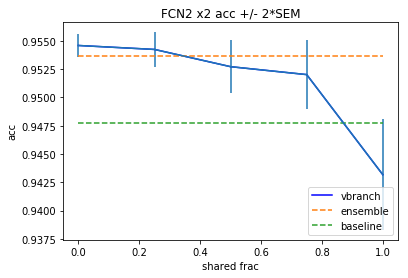

In [10]:
results_list = list(results.items())
results_list.sort()
results_list = np.array(results_list)

plt.plot(results_list[:, 0], results_list[:,1], label='vbranch', color='blue')
trials = 4
error = np.sort(np.array(list(results_std.items())), 0)[:, 1] / np.sqrt(trials)
plt.errorbar(results_list[:, 0], results_list[:,1], error*2)

plt.plot(results_list[:, 0], [avg_acc]*len(results_list), label='ensemble', linestyle='--')
plt.plot(results_list[:, 0], [baseline]*len(results_list), label='baseline', linestyle='--')

plt.legend(loc='lower right')
plt.xlabel('shared frac')
plt.ylabel('acc')
plt.title('{} x{} acc +/- 2*SEM'.format(architecture.upper(), branches))

if not os.path.isdir('figs'):
    os.system('mkdir figs')
    
plt.savefig('figs/{}-{}-results.png'.format(architecture, branches))
plt.show()

## Model Parameters

In [2]:
import vbranch as vb
from experiments.classification import baseline as baseline_expt
from experiments.classification import vbranch as vb_expt

In [12]:
import tensorflow as tf

num_classes = 10

tf.reset_default_graph()
inputs = tf.placeholder('float32', [None, 784])
labels = tf.placeholder('float32', [None, num_classes])

# Baseline
model = baseline_expt.build_model(architecture, inputs, labels, num_classes,1, test=True)
baseline_params = model.count_parameters()

# Vbranch params
vbranch_params = []
for frac in [0, 0.25, 0.5, 0.75, 1]:
    tf.reset_default_graph()
    
    inputs = tf.placeholder('float32', [None, 784])
    labels = tf.placeholder('float32', [None, num_classes])

    model = vb_expt.build_model(architecture,[inputs]*branches,[labels]*branches, 
                                num_classes, branches, 1, frac, test=True)
    vbranch_params.append(model.count_parameters())

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
param_ratio = [p / baseline_params for p in vbranch_params]
ideal_ratio = branches - np.array(shared_frac_list)**2 * (branches-1)

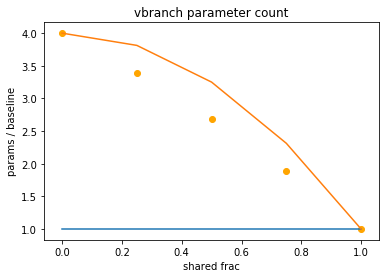

In [18]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('vbranch parameter count')

plt.savefig('figs/vbranch-parameter-count.png')
plt.show()